# Анализ оттока клиентов банка

**Общая задача:**<br>
Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

**Подзадачи:**<br>
1. Изучение датасета;
2. Предобработка данных - удаление выбросов, заполнение пропусков, изменение типа;
3. Выделение основных признаков ушедших клиентов:<br>
    3.1. Написание кода;<br>
    3.2. Построение графиков;<br>
4. Формулировка и проверка гипотез:<br>
    4.1. Гипотеза о различии среднего дохода между теми клиентами, которые ушли и теми, которые остались;<br>
    4.2. Гипотеза о различии среднего счета кредитного скоринга между теми клиентами, которые ушли и теми, которые остались;
5. Создание дашборда;
6. Подготовка презентации.

## Ссылки на внешние файлы
* [**Дашборд**](https://public.tableau.com/app/profile/tank6691/viz/bank_dashboard_16526322202670/Dashboard1?publish=yes)
* [**Презентация**](https://drive.google.com/file/d/1rg-vUKo4UuuOQoksYmiOlqRkbwtnXpNH/view?usp=sharing)

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
from scipy import stats as st

In [2]:
# Функция построения диаграммы и расчета процента ушедших клиентов для группы по признаку
def graph(col):
    pd.pivot_table(data, values='userid', index=col, columns=['churn'], aggfunc='count').plot(kind='bar')
    plt.grid(visible=True)
    plt.xticks(rotation=30)
    plt.ylabel('Client count')
    plt.xlabel(col.capitalize().replace("_", " "))
    plt.title(f'Client segregation based on {col.replace("_", " ")}')
    
    print(f'Расчет процента ушедших клиентов по признаку {col}:')
    return (data.query('churn == 1').groupby(col).agg('count').sort_values(by='userid').userid /
            data.groupby(col).agg('count').sort_values(by='userid').userid * 100)

In [3]:
# Функция построения диаграммы в разрезе нескольких факторов
def graph_2i(col1, col2):
    pd.pivot_table(data, values='userid', index=[col1, col2], columns=['churn'], aggfunc='count').plot(kind='bar')
    plt.grid(visible=True)
    plt.xticks(rotation=30)
    plt.ylabel('Client count')
    plt.xlabel([col1.capitalize().replace("_", " "), col2.capitalize().replace("_", " ")])
    plt.title(f'Client segregation based on {col1.replace("_", " ")}, {col2.replace("_", " ")}')

## 1. Изучение датасета
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

In [4]:
data = pd.read_csv('bank_dataset.csv')
data = data.rename(str.lower, axis='columns').rename(columns={'creditcard': 'credit_card'})
data.head()

,userid,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


Колонки содержат следующую информацию о клиентах:
* `userid` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `city` — город,
* `gender` — пол,
* `age` — возраст,
* `objects` — количество объектов в собственности,
* `balance` — баланс на счёте,
* `products` — количество продуктов, которыми пользуется клиент,
* `credit_card` — есть ли кредитная карта,
* `loyalty` — активный клиент,
* `estimated_salary` — заработная плата клиента,
* `churn` — ушёл или нет.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Датасет состоит из 10000 записей.<br>
Видим, что пустые значения есть только в колонке `'balance'`. Весьма вероятно, что такие клиенты пользуются банковскими продуктами, которые не предполагают начиние дебетового баланса.

## 2. Предобработка данных

Типы данных для каждого столбца были правильно присвоены автоматически, поэтому пропустим этот этап.

### 2.1. Поиск и устранение выбросов
Сначала изучим категориальные данные - столбцы `'gender'`, `'credit_card'`, `'loyalty'` и `'churn'`:

In [6]:
for name in ['gender', 'credit_card', 'loyalty', 'churn']:
    print(f'Уникальные значения столбца {name}: {data[name].unique()}')

Уникальные значения столбца gender: ['Ж' 'М']
Уникальные значения столбца credit_card: [1 0]
Уникальные значения столбца loyalty: [1 0]
Уникальные значения столбца churn: [1 0]


Здесь проблем нет. Теперь изучим данные столбцов `'score'`, `'balance'` и `'estimated_salary'`:

In [7]:
for name in ['score', 'balance', 'estimated_salary']:
    print(f'\nИнформация о столбце {name}:\n{data[name].describe()}')


Информация о столбце score:
count   10,000.00
mean       650.53
std         96.65
min        350.00
25%        584.00
50%        652.00
75%        718.00
max        850.00
Name: score, dtype: float64

Информация о столбце balance:
count     6,383.00
mean    119,827.49
std      30,095.06
min       3,768.69
25%     100,181.98
50%     119,839.69
75%     139,512.29
max     250,898.09
Name: balance, dtype: float64

Информация о столбце estimated_salary:
count    10,000.00
mean    100,090.24
std      57,510.49
min          11.58
25%      51,002.11
50%     100,193.91
75%     149,388.25
max     199,992.48
Name: estimated_salary, dtype: float64


Данные столбца `'score'` вопросов не вызывают, а для столбцов `'balance'` и `'estimated_salary'` построим диаграммы разброса.

#### 2.1.1. Столбец `'balance'`

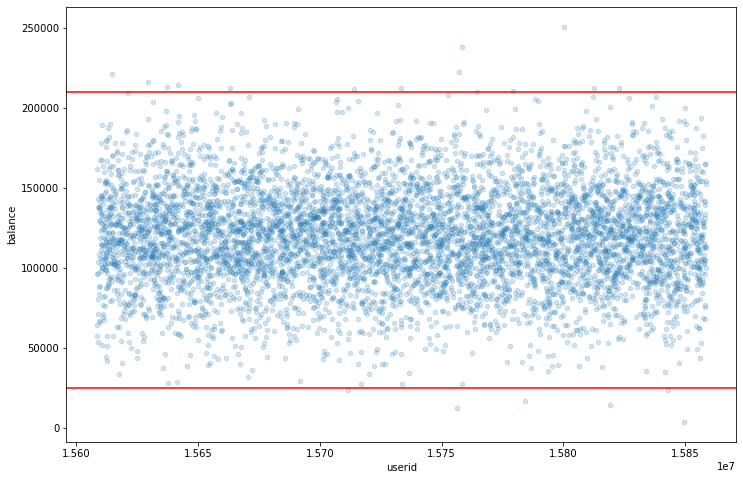

In [8]:
data.plot(kind='scatter', x='userid', y='balance', alpha=0.2)
plt.axhline(y=210000, color='r', linestyle='-')
plt.axhline(y=25000, color='r', linestyle='-')

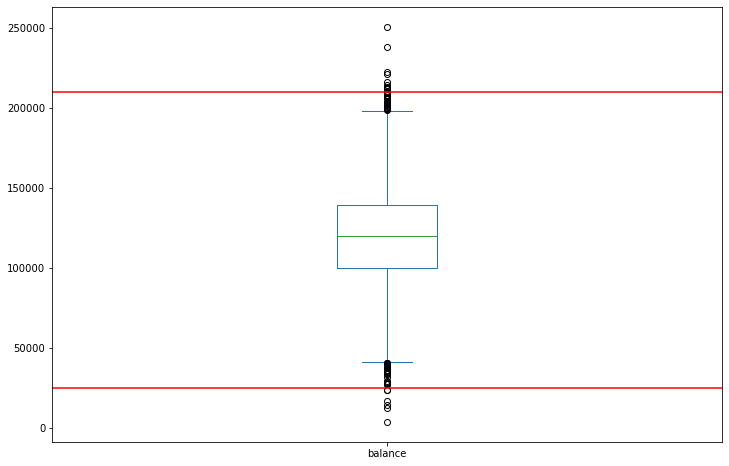

In [9]:
data.balance.plot(kind='box')
plt.axhline(y=210000, color='r', linestyle='-')
plt.axhline(y=25000, color='r', linestyle='-')

Будем считать выбросами значения больше 210000 и меньше 25000. Удалим их:

In [10]:
data = data.query('(25000 < balance < 210000) | (balance != balance)').reset_index(drop=True)

In [11]:
print(f'Удалено {10000 - len(data)} строк.')

Удалено 19 строк.


#### 2.1.2. Столбец `'estimated_salary'`

<AxesSubplot:xlabel='userid', ylabel='estimated_salary'>

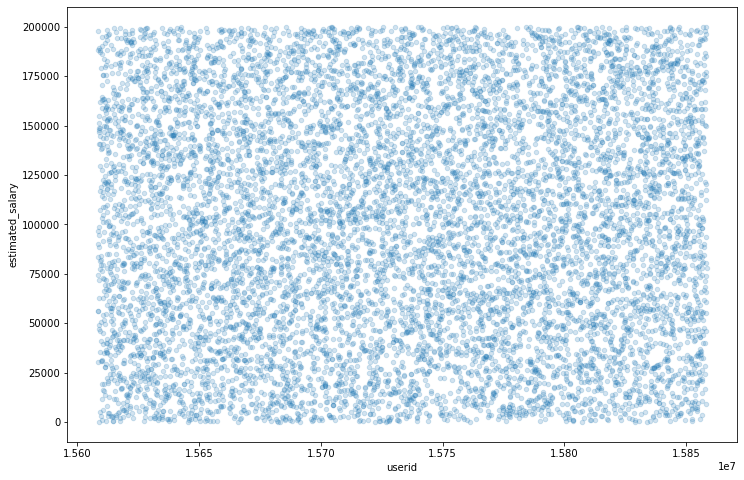

In [12]:
data.plot(kind='scatter', x='userid', y='estimated_salary', alpha=0.2)

<AxesSubplot:>

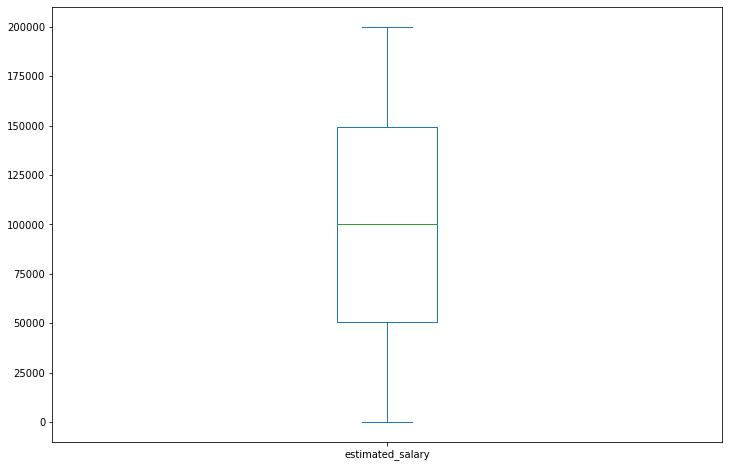

In [13]:
data.estimated_salary.plot(kind='box')

Хоть данные и имеют довольно большой диапазон, они расположены довольно плотно, поэтому принимаем, что выбросов здесь нет.

### 2.2. Обработка пропусков

Пропущенные значения есть только в столбце `"balance"` - 3617 значений.<br>
Они могут говорить о том, что клиент не имеет дебетового счета в банке, в таком случае отсутствие значения не является проблемой, и даже наоборот - заполнение пропусков средними или медианными значениями будет ошибкой.
Нет необходимости заполнять пропуски какими-то значениями-индикаторами, поскольку в работе не применяются модели машинного обучения, наличие пропусков для которых критично.<br>
Анализ будет вестись по категориям, на которые пользователи будут разделены по количеству средств на счете - в таком случае пользователям, для которых поле `"balance"` не заполнено, будет присвоена соответствующая группа **"нет дебетового счета"**.

In [14]:
data.query('balance != balance').fillna(0).groupby('credit_card').agg('count')['balance']

credit_card
0    1025
1    2592
Name: balance, dtype: int64

Подтверждаем догадку - клиенты, у которых есть кредитная карта, в 2.5 раза чаще не имеют дебетовых счетов.

## 3. Выделение портрета клиентов, склонных уходить из банка
Согласно поставленной задаче, выделим ушедших клиентов и опишем их поведение:

In [15]:
print(f'Количество ушедних клиентов в датасете: {len(data.query("churn == 1"))}')

Количество ушедних клиентов в датасете: 2026


Снача изучем критериальные признаки, затем перейдем к численным:

### 3.1. Город

Расчет процента ушедших клиентов по признаку city:


city
Ростов Великий   32.47
Рыбинск          16.52
Ярославль        16.07
Name: userid, dtype: float64

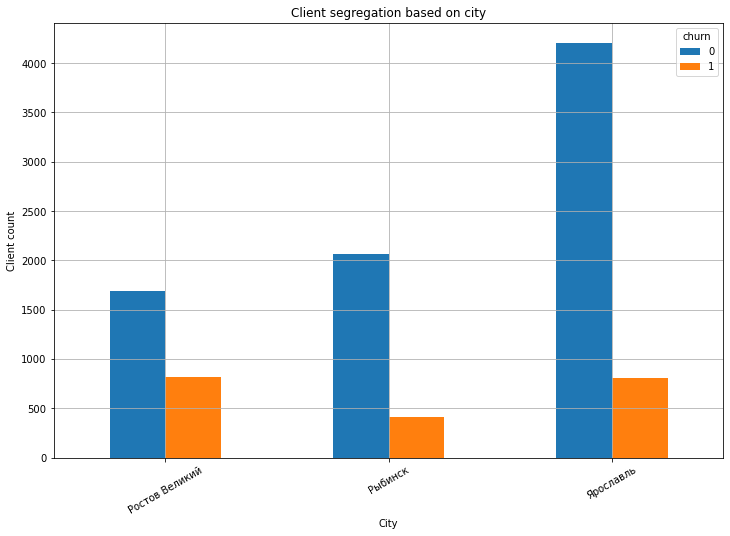

In [16]:
graph('city')

Видим, что относительно общего количества клиентов в городе, клиенты из *Рыбинска* и *Ярославля* уходят примерно одинаково (около **16%**). А вот в *Великом Ростове* эта цифра в два раза выше - примерно **32%**.

### 3.2. Пол

Расчет процента ушедших клиентов по признаку gender:


gender
Ж   24.97
М   16.41
Name: userid, dtype: float64

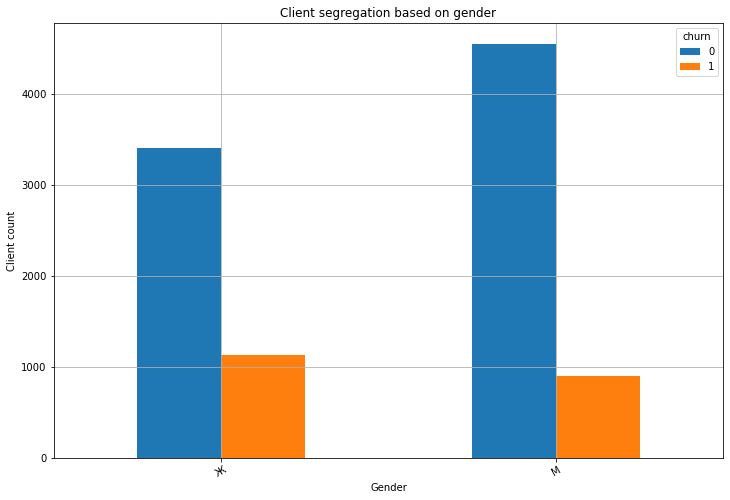

In [17]:
graph('gender')

In [18]:
# Расчет отношения клиентов по полу
(100 - list(data.groupby('gender').agg('count').sort_values(by='userid').userid)[0] /
 list(data.groupby('gender').agg('count').sort_values(by='userid').userid)[1] * 100)

16.761520102808888

Всего *клиентов-мужчин* в банке на **16%** больше. Но среди ушедших клиентов *женщин* на **9%** больше (**25%** против **16%**).

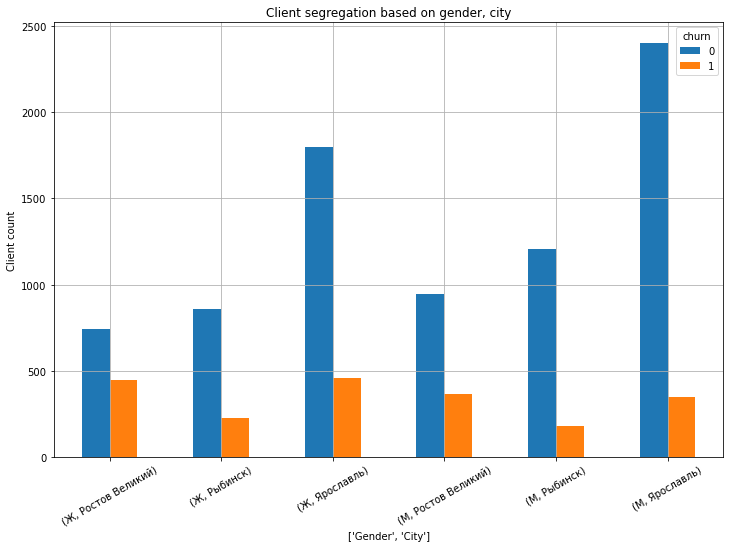

In [19]:
graph_2i('gender', 'city')

Видим, что клиентов-мужчин в каждом городе больше, но относительно числа участников группы во всех случаях женщины уходят чаще.

### 3.3. Количество объектов в собственности

Расчет процента ушедших клиентов по признаку objects:


objects
0    22.82
1    22.34
2    19.12
3    21.02
4    20.49
5    20.57
6    20.19
7    17.22
8    19.16
9    21.51
10   20.61
Name: userid, dtype: float64

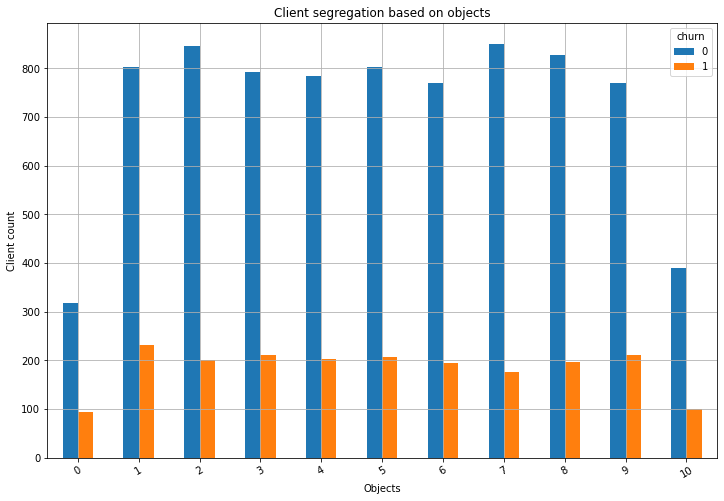

In [20]:
graph('objects')

Видим, что от количества объектов в собственности вероятность ухода клиента зависит слабо - распределение примерно одинаковое.<br>
Чуть *чаще* уходят клиенты **без собственности** или с **1 объектом**, *наиболее редко* - клиенты с **7 объектами**.

### 3.4. Количество используемых продуктов

Расчет процента ушедших клиентов по признаку products:


products
4   100.00
3    82.64
2     7.54
1    27.63
Name: userid, dtype: float64

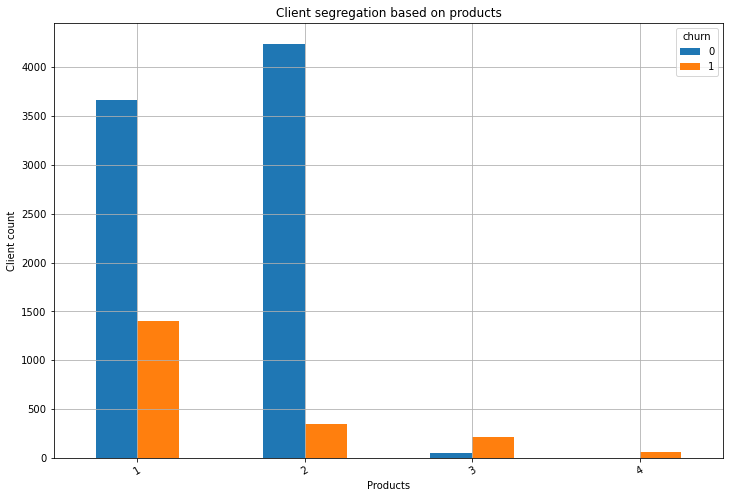

In [21]:
graph('products')

Видим, что количество клиентов с **1** и **2** продуктами примерно равно, и клиенты, пользующиеся двумя продуктами уходят значительно (практически в **4 раза**) реже, чем клиенты с одним продуктом.<br>
Для клиентов, пользующихся **3** и **4** продуктами, выборка нерепрезентативна, поэтому выводы по ним делать некорректно.

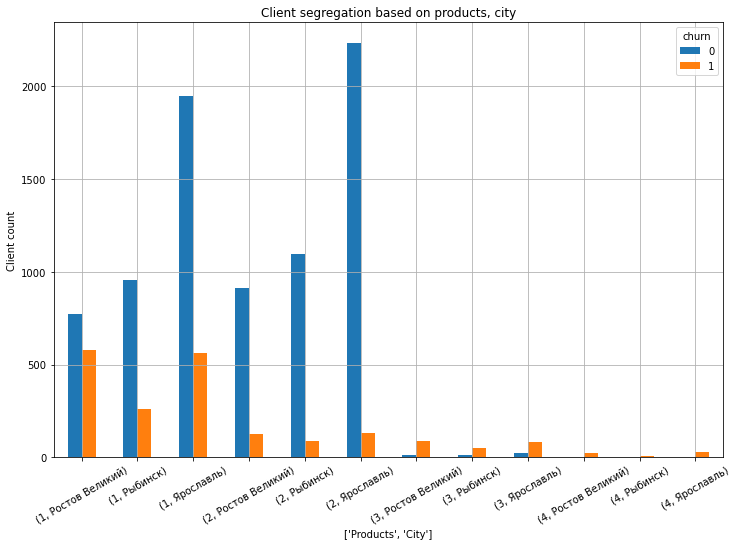

In [22]:
graph_2i('products', 'city')

В разбивке по городам видим, что в Великом Ростове клиенты с 1 объектом в совственности уходят значительно чаще, чем в других городах.

### 3.5. Наличие кредитной карты

Расчет процента ушедших клиентов по признаку credit_card:


credit_card
0   20.62
1   20.16
Name: userid, dtype: float64

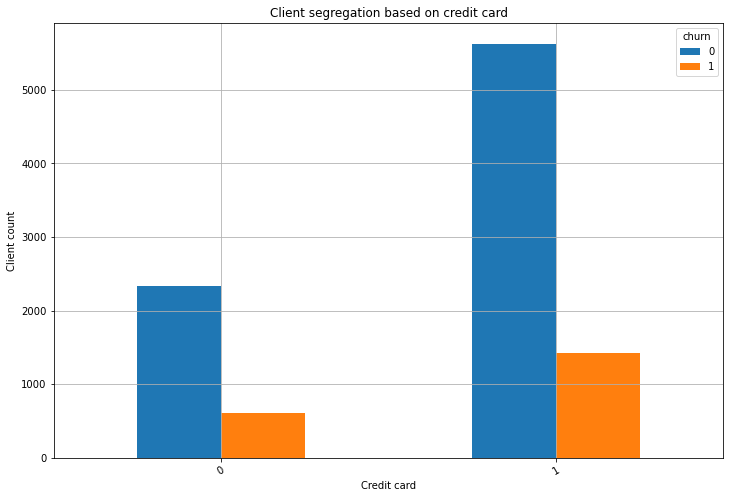

In [23]:
graph('credit_card')

In [24]:
# Расчет отношения клиентов по наличию кредитной карты
(100 - list(data.groupby('credit_card').agg('count').sort_values(by='userid').userid)[0] /
 list(data.groupby('credit_card').agg('count').sort_values(by='userid').userid)[1] * 100)

58.36526181353768

Видим, что клиентов, пользующихся кредитными картами пользуются чуть меньше **42%** от общего числа.

На вероятность ухода наличие карты практически не влияет - около **20%** клиентов уходят в обоих случаях.

### 3.6. Активность

Расчет процента ушедших клиентов по признаку loyalty:


loyalty
0   26.80
1   14.18
Name: userid, dtype: float64

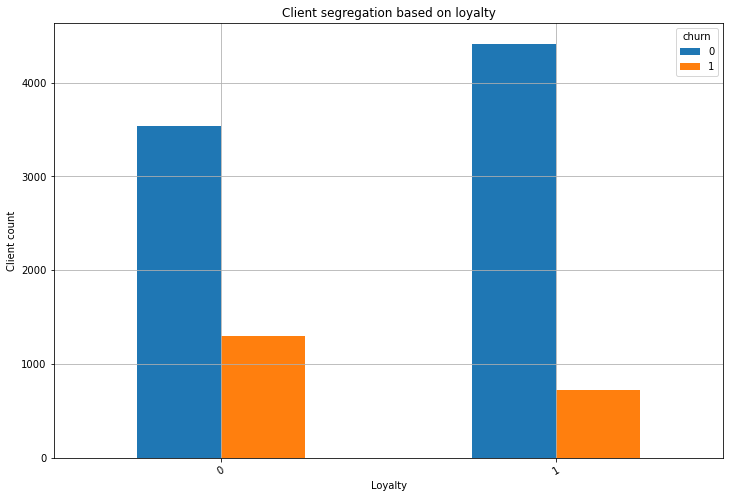

In [25]:
graph('loyalty')

Количество активных и неактивных клиентов примерно одинаково, и активные клиенты уходят на **12%** реже, чем неактивные.

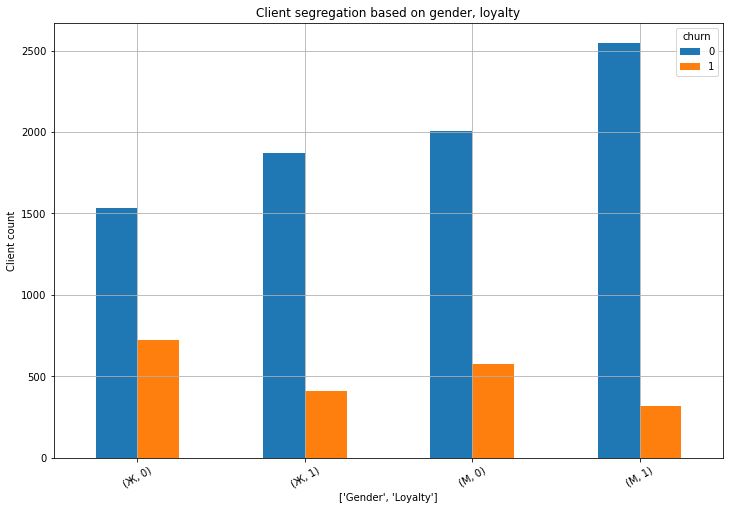

In [26]:
graph_2i('gender', 'loyalty')

Картина схожая - независимо от активности, клиенты-женщины склонны уходить чаще.

Теперь изучим численные признаки. Для этого разделим клиентов на группы по этим признакам:

### 3.7. Возраст

In [27]:
# Функция присвоения возрастной группы (разбиение на 5 примерно одинаковых по количеству участников категорий)
def age_cat(age):
    if age <= 30:
        return '18-30'
    elif 30 < age <= 35:
        return '31-35'
    elif 35 < age <= 39:
        return '36-39'
    elif 39 < age <= 46:
        return '40-46'
    elif age > 46:
        return '46+'

In [28]:
# Делим клиентов по возрасту на 5 групп
data['age_category'] = data.age.apply(age_cat)
data[['age', 'age_category']].head()

,age,age_category
0,42,40-46
1,41,40-46
2,42,40-46
3,39,36-39
4,43,40-46


Расчет процента ушедших клиентов по признаку age_category:


age_category
18-30    7.48
31-35    9.07
36-39   13.61
40-46   26.84
46+     45.86
Name: userid, dtype: float64

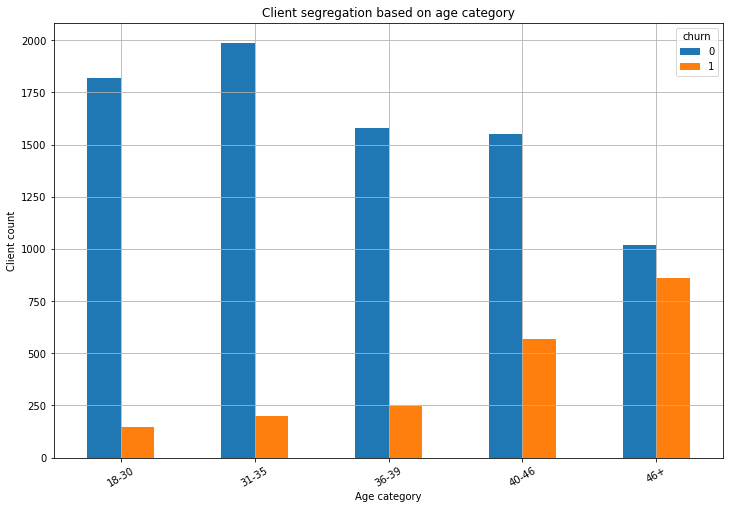

In [29]:
graph('age_category')

Видим, что при примерно схожих размерах возрастных групп с увеличением возраста увеличивается и шанс ухода клиента - от **7.5%** для категории "18-30" до **46%** для категории "46+".

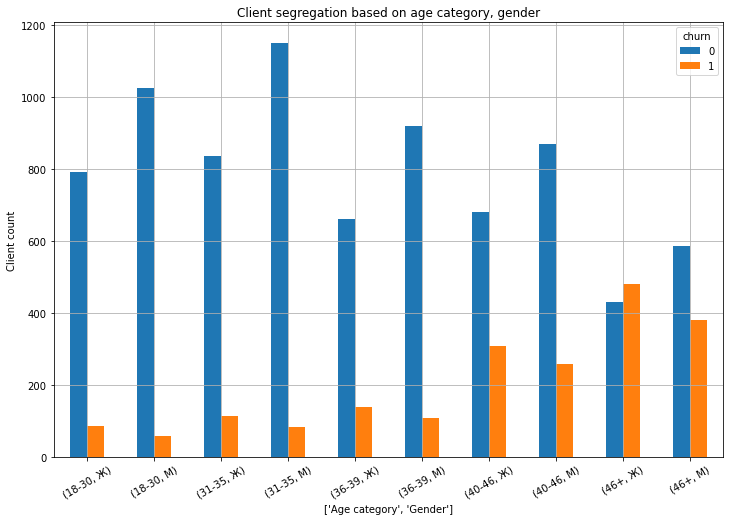

In [30]:
graph_2i('age_category', 'gender')

Независимо от разреза данных, общая парадигма не меняется - женщины старшего возраста склонны уходить чаще.

### 3.8. Примерная зарплата

In [31]:
# Функция присвоения зарплатной группы (разбиение на 5 примерно одинаковых по количеству участников категорий)
def salary_cat(salary):
    if salary <= 41000:
        return 'Меньше 41000'
    elif 41000 < salary <= 80000:
        return '41000 - 80000'
    elif 80000 < salary <= 120000:
        return '80000 - 120000'
    elif 120000 < salary <= 160000:
        return '120000 - 160000'
    elif salary > 160000:
        return 'Больше 160000'

In [32]:
# Делим клиентов по зарплате на 5 групп
data['salary_category'] = data.estimated_salary.apply(salary_cat)
data[['estimated_salary', 'salary_category']].head()

,estimated_salary,salary_category
0,"101,348.88",80000 - 120000
1,"112,542.58",80000 - 120000
2,"113,931.57",80000 - 120000
3,"93,826.63",80000 - 120000
4,"79,084.10",41000 - 80000


Расчет процента ушедших клиентов по признаку salary_category:


salary_category
120000 - 160000   20.15
41000 - 80000     20.01
80000 - 120000    19.99
Больше 160000     21.44
Меньше 41000      19.91
Name: userid, dtype: float64

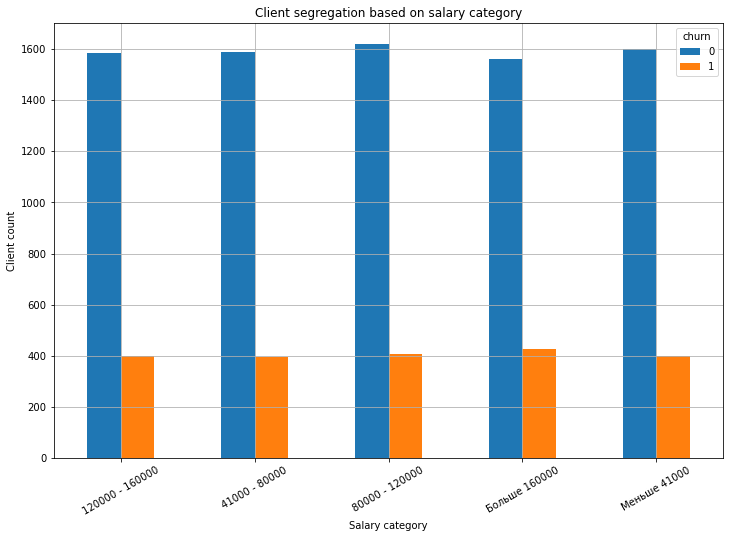

In [33]:
graph('salary_category')

Видим, что зарплата практически не влияет на вероятность ухода клиента. Меньше всего (**19.91%**) ушедших клиентов были в группе "Меньше 41000", больше всего (**21.44%**) - в группе "больше 160000".

### 3.9. Дебетовый баланс

In [34]:
# Функция присвоения балансной группы (разбиение на 5 примерно одинаковых по количеству участников категорий + 1 группа без счета)
def balance_cat(balance):
    if balance <= 95000:
        return 'Меньше 95000'
    elif 95000 < balance <= 112000:
        return '95000 - 112000'
    elif 112000 < balance <= 127000:
        return '112000 - 127000'
    elif 127000 < balance <= 144000:
        return '127000 - 144000'
    elif balance > 144000:
        return 'Больше 144000'
    else:
        return 'Нет дебитового счета'

In [35]:
# Делим клиентов по балансу на 6 групп
data['balance_category'] = data.balance.apply(balance_cat)
data[['balance', 'balance_category']].head()

,balance,balance_category
0,NaN,Нет дебитового счета
1,"83,807.86",Меньше 95000
2,"159,660.80",Больше 144000
3,NaN,Нет дебитового счета
4,"125,510.82",112000 - 127000


Расчет процента ушедших клиентов по признаку balance_category:


balance_category
112000 - 127000        26.91
127000 - 144000        24.64
95000 - 112000         25.19
Больше 144000          22.76
Меньше 95000           20.23
Нет дебитового счета   13.82
Name: userid, dtype: float64

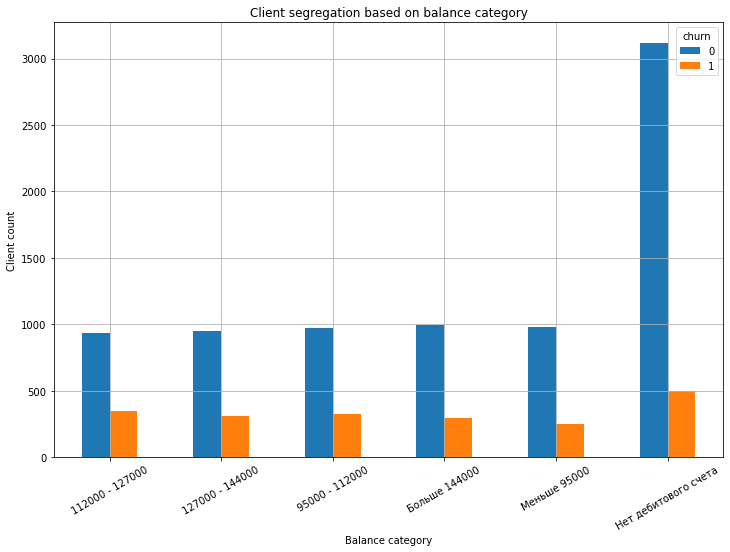

In [36]:
graph('balance_category')

Ушедшие клиенты, не имевшие дебетового баланса, составляют **13.8%** от всех клиентов, не имеющих такового.

В разрезе по остальным  группам видно, что реже всего уходят клиенты с балансом **менее 95000**. Чаще всех - клиенты с балансом **112000 - 127000**.

### 3.10. Кредитный скоринг

In [37]:
# Функция присвоения группы кредитного скоринга (разбиение на 5 примерно одинаковых по количеству участников категорий)
def score_cat(score):
    if score <= 566:
        return 'Меньше 566'
    elif 566 < score <= 627:
        return '566 - 627'
    elif 627 < score <= 678:
        return '628 - 678'
    elif 678 < score <= 735:
        return '679 - 735'
    elif score > 735:
        return 'Больше 735'

In [38]:
# Делим клиентов по кредитному скорингу на 5 групп
data['score_category'] = data.score.apply(score_cat)
data[['score', 'score_category']].head()

,score,score_category
0,619,566 - 627
1,608,566 - 627
2,502,Меньше 566
3,699,679 - 735
4,850,Больше 735


Расчет процента ушедших клиентов по признаку score_category:


score_category
566 - 627    20.73
628 - 678    19.51
679 - 735    18.34
Больше 735   20.41
Меньше 566   22.47
Name: userid, dtype: float64

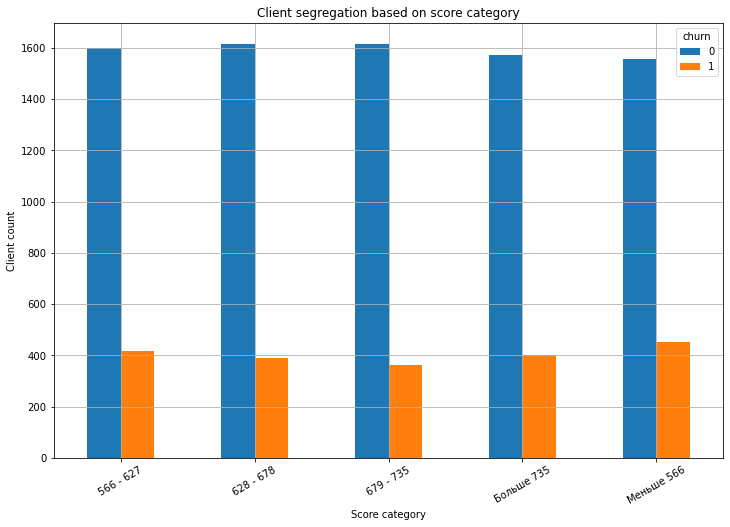

In [39]:
graph('score_category')

Видим, что чаще всего (**22,5%**) уходят клиенты с плохим кредитным скорингом (меньше 566), реже всего - клиенты группы "679 - 735" (**18.3%**).

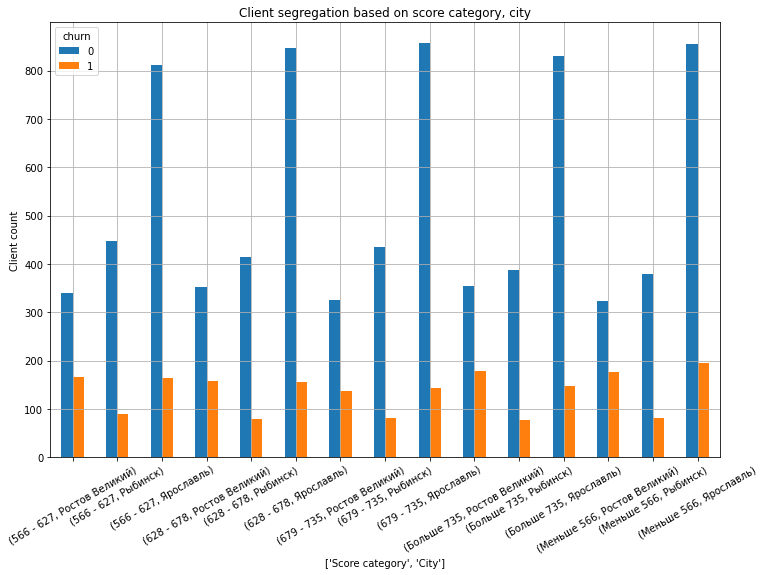

In [40]:
graph_2i('score_category', 'city')

Чаще других уходят клиенты с плохим кредитным скорингом, проживающие в Великом Ростове.

## 4. Формулировка и проверка гипотез

### 4.1. Различие дохода между теми клиентами, которые ушли и теми, которые остались

**Нулевая** гипотеза будет звучать как "средние доходы тех клиентов, которые ушли и тех, которые остались, равны".<br>
Тогда **первая** гипотеза будет звучать "средние доходы тех клиентов, которые ушли и тех, которые остались, различаются".

Критический уровень статистической значимости задаем равным 5%.

In [41]:
alpha = 0.05

results = st.ttest_ind(data.query('churn == 0').estimated_salary,
                       data.query('churn == 1').estimated_salary,
                       equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 0.2854368832753803
Не получилось отвергнуть нулевую гипотезу.


Принимаем решение, что нулевая гипотеза **верна** - средние доходы ушедших и оставшихся клиентов равны.

### 4.2. Различие счета кредитного скоринга между теми клиентами, которые ушли и теми, которые остались

**Нулевая** гипотеза будет звучать как "средний счет кредитного скоринга тех клиентов, которые ушли и тех, которые остались, одинаков".<br>
Тогда **первая** гипотеза будет звучать "средний счет кредитного скоринга тех клиентов, которые ушли и тех, которые остались, различается".

Критический уровень статистической значимости оставляем равным 5%.

In [42]:
results = st.ttest_ind(data.query('churn == 0').score,
                       data.query('churn == 1').score,
                       equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 0.007651895854594523
Отвергаем нулевую гипотезу.


Принимаем, что нулевая гипотеза **не верна**. Судя по p-значению, вероятность равенства средней среднего счета кредитного скоринга оставшихся и ушедших очень мала. В таком случае, посчитаем среднее значение счета кредитного скоринга для каждой из групп клиентов и сравним их.

In [43]:
print(f'Среднее значение кредитного скоринга оставшихся клиентов: {round(data.query("churn == 0").score.mean())}')
print(f'Среднее значение кредитного скоринга ушедших клиентов: {round(data.query("churn == 1").score.mean())}')

Среднее значение кредитного скоринга оставшихся клиентов: 652
Среднее значение кредитного скоринга ушедших клиентов: 645


## 5. Вывод

После анализа предоставленных данных был создан портрет клиентов, склонных уходить из банка:

1. Скорее всего, женщина;
2. Возрастная группа "46+";
3. Проживает в Великом Ростове;
4. Имеет в собственности один объект или не имеет собственности вовсе;
5. Использует только один банковский продукт;
6. Наличие кредитной карты практически не влияет на вероятность ухода;
7. Не является активным клиентом банка;
8. Имеет зарплату более 160000 рублей;
9. Имеет баланс 112000 - 127000 рублей;
10. Имеет счет кредитного скоринга меньше 566.

Были проверены две статистические гипотезы:
1. Гипотеза о равенстве средних доходов ушедших и оставшихся клиентов принята;
2. Гипотеза о равенстве счета кредитного скоринга ушедших и оставшихся клиентов отвергнута - среднее значение ушедших клиентов меньше, чем у оставшихся.

Для удержания подобных клиентов можно использовать следующие действия:
1. Поскольку у подобных клиентов мало объектов в собственности, но неплохая зарплата, то можно предлагать им ипотечные или автокредиты;
2. Поскольку клиент находится в возрастной группе "46+", имеет неплохую зарплату и некоторые сбережения в банке, можно предлагать накопительные счета или вклады ("на будущее внуков", возможно);
3. Наличие кредитной карты практически не влияет на вероятность ухода, поэтому тратить деньги на рекламу этих продуктов подобным клиентам не стоит;
4. Весьма вероятно, что клиентам-женщинам возрастной группы "46+" будет интересно рассмотреть карты с кэшбэком на товары для ухода за собой, товары для дома, досуга и домашних животных;
5. Так как активные клиенты уходят значительно реже, стоит рассмотреть возможность введения системы бонусов за покупки по карте (повышенный кэшбэк, специальные предложения и т.д.).